The dataset is housing data for the city of Ames, Iowa, United States from 2006 to 2010. 
The goal is to build a linear regression model to predict sale price with given features such as living space area,
garage area, house style.

# Step1: Import Libs and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
%matplotlib inline

In [2]:
data = pd.read_csv('AmesHousing.tsv', delimiter="\t")
print(data.shape,data.columns)
print(data.head(5))

(2930, 82) Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr B

# Step 2: Model with Simplest Tranform, Select, Train & Test functions
Build the model with the simplest algorithms and see what the outcome looks like

In [3]:
#First, just set up the functions with very simple commands. 
#Will keep updating those functins as we explore the data more and more

def transform_features(df):
    return df

def select_features(df):
    return df[["Gr Liv Area", "SalePrice"]]

def train_and_test(df):  
    train = df[:1460]
    test = df[1460:]
    
    ## You can use `pd.DataFrame.select_dtypes()` to specify column types
    ## and return only those columns as a data frame.
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    
    ## You can use `pd.Series.drop()` to drop a value.
    features = numeric_train.columns.drop("SalePrice")
    lr = LinearRegression()
    lr.fit(train[features], train["SalePrice"])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test["SalePrice"], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

transform_df = transform_features(data)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

57088.25161263909

The RMSE from this simple model is quite large

# Step 3: Explore How the Data Can Be Tranformed

3.1: Add additional helpful columns, drop the ones not useful

In [4]:
#create a few additional useful variables
data['Yrs Since Built'] = data['Yr Sold'] - data['Year Built']
data['Yrs Since Remod'] = data['Yr Sold'] - data['Year Remod/Add']

#check to see if there are records with data['Yrs Since Built']<0
#or records with data[Years Since Remod']<0
print(data[(data['Yrs Since Built']<0) | (data['Yrs Since Remod']<0)])

#Drop records with data['Yrs Since Built']<0 or data[Years Since Remod']<0
data_clean = data.drop(data[(data['Yrs Since Built']<0) | (data['Yrs Since Remod']<0)].index.values, axis=0)

#No longer need Year built and Year Remod/Add columns
#Drop columns not useful or leaks information about the sale
#Also drop columns not useful  
data_clean.drop(['Year Built','Year Remod/Add','Yr Sold','Mo Sold','Sale Type','Sale Condition','PID','Order'], axis=1, inplace = True)
print(data_clean.shape)


      Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
1702   1703  528120010           60        RL         134.0     16659   Pave   
2180   2181  908154195           20        RL         128.0     39290   Pave   
2181   2182  908154205           60        RL         130.0     40094   Pave   

     Alley Lot Shape Land Contour  ... Fence Misc Feature Misc Val Mo Sold  \
1702   NaN       IR1          Lvl  ...   NaN          NaN        0       6   
2180   NaN       IR1          Bnk  ...   NaN         Elev    17000      10   
2181   NaN       IR1          Bnk  ...   NaN          NaN        0      10   

     Yr Sold Sale Type Sale Condition SalePrice  Yrs Since Built  \
1702    2007       New        Partial    260116                0   
2180    2007       New        Partial    183850               -1   
2181    2007       New        Partial    184750                0   

      Yrs Since Remod  
1702               -1  
2180               -2  
2181               -1

3.2: Look into columns with null values, the ones with too many nulls should be dropped, the ones with 0%-5% nulls can be fixed

In [5]:
#Check nulls:
null_check = data_clean.isnull().sum().sort_values(ascending = False)/len(data)*100
    
#fill in null values for columns with <=5% null value with most frequent values
null_fill =  null_check[(null_check <5) & (null_check>0)]
print(null_check.head(15))
values = {}
for i in null_fill.index:
    values[i] = data_clean[i].mode()[0]
print(values)
data_clean.fillna(value=values, inplace = True)

#drop columns with >5% null values:
null_drop =  null_check[null_check >5]
data_clean.drop(null_drop.index, axis=1, inplace=True)

#Check to make sure that columns with <=5% null value are replaced with most frequent values
print(data_clean.isnull().sum().sort_values(ascending = False).head(15)/len(data)*100)
print(data_clean.shape)

Pool QC           99.453925
Misc Feature      96.313993
Alley             93.139932
Fence             80.375427
Fireplace Qu      48.532423
Lot Frontage      16.723549
Garage Yr Blt      5.426621
Garage Qual        5.426621
Garage Cond        5.426621
Garage Finish      5.426621
Garage Type        5.358362
Bsmt Exposure      2.832765
BsmtFin Type 2     2.764505
BsmtFin Type 1     2.730375
Bsmt Cond          2.730375
dtype: float64
{'Bsmt Exposure': 'No', 'BsmtFin Type 2': 'Unf', 'BsmtFin Type 1': 'GLQ', 'Bsmt Cond': 'TA', 'Bsmt Qual': 'TA', 'Mas Vnr Type': 'None', 'Mas Vnr Area': 0.0, 'Bsmt Half Bath': 0.0, 'Bsmt Full Bath': 0.0, 'Garage Cars': 2.0, 'Total Bsmt SF': 0.0, 'Bsmt Unf SF': 0.0, 'BsmtFin SF 2': 0.0, 'Electrical': 'SBrkr', 'BsmtFin SF 1': 0.0, 'Garage Area': 0.0}
Yrs Since Remod    0.0
BsmtFin SF 2       0.0
BsmtFin SF 1       0.0
BsmtFin Type 1     0.0
Bsmt Exposure      0.0
Bsmt Cond          0.0
Bsmt Qual          0.0
Foundation         0.0
Exter Cond         0.0
Exter Qu

3.3: Now update transform_features functions with the steps developed from the previous 2 analysis

In [6]:
def transform_features(data):
    #create a few additional useful variables
    data['Yrs Since Built'] = data['Yr Sold'] - data['Year Built']
    data['Yrs Since Remod'] = data['Yr Sold'] - data['Year Remod/Add']

    #Drop records with data['Yrs Since Built']<0 or data[Years Since Remod']<0
    data_clean = data.drop(data[(data['Yrs Since Built']<0) | (data['Yrs Since Remod']<0)].index.values, axis=0)

    #No longer need Year built and Year Remod/Add columns
    #Drop columns not useful or leaks information about the sale
    #Also drop columns not useful  
    data_clean.drop(['Year Built','Year Remod/Add','Yr Sold','Mo Sold','Sale Type','Sale Condition','PID','Order'], axis=1, inplace = True)

    #Check nulls:
    null_check = data_clean.isnull().sum().sort_values(ascending = False)/len(data)*100
    
    #fill in null values for columns with <=5% null value with most frequent values
    null_fill =  null_check[(null_check <5) & (null_check>0)]
    values = {}
    for i in null_fill.index:
        values[i] = data_clean[i].mode()[0]
    data_clean.fillna(value=values, inplace = True)

    #drop columns with >5% null values:
    null_drop =  null_check[null_check >5]
    data_clean.drop(null_drop.index, axis=1, inplace=True)
    
    return data_clean

# Step 4: Explore and Find Out How to Best Select Features

4.1: Look into correlations among numerical columns 

SalePrice          1.000000
Overall Qual       0.801206
Gr Liv Area        0.717596
Garage Cars        0.648361
Total Bsmt SF      0.644012
Garage Area        0.641425
1st Flr SF         0.635185
Yrs Since Built    0.558979
Full Bath          0.546118
Yrs Since Remod    0.534985
Mas Vnr Area       0.506983
TotRms AbvGrd      0.498574
Fireplaces         0.474831
BsmtFin SF 1       0.439284
Wood Deck SF       0.328183
Open Porch SF      0.316262
Half Bath          0.284871
Bsmt Full Bath     0.276258
2nd Flr SF         0.269601
Lot Area           0.267520
Bsmt Unf SF        0.182751
Bedroom AbvGr      0.143916
Enclosed Porch     0.128685
Kitchen AbvGr      0.119760
Screen Porch       0.112280
Overall Cond       0.101540
MS SubClass        0.085128
Pool Area          0.068438
Low Qual Fin SF    0.037629
Bsmt Half Bath     0.035875
3Ssn Porch         0.032268
Misc Val           0.019273
BsmtFin SF 2       0.006127
Name: SalePrice, dtype: float64 (33,)
AxesSubplot(0.125,0.125;0.62x0.755)


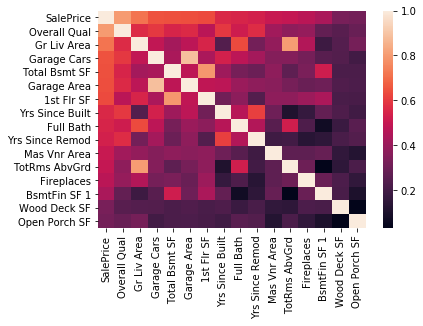

In [7]:
data_clean = transform_features(data)

#Check how strongly each variable is correlated to SalePrice
corr_vals = data_clean.corr()['SalePrice'].abs().sort_values(ascending=False)
print(corr_vals.head(100), corr_vals.shape)

#Usig 0.3 as a threshold, the ones above 0.3 are considered strongly correlated
num_strong_corrs = corr_vals[corr_vals>0.3]

#Use the heatmap to check how strongly the variables with strong correlations to SalePrice are related to each other. 
corrmat = data_clean[num_strong_corrs.index].corr().abs()
print(sns.heatmap(corrmat))


In [8]:
#Those pairs have strong correlations:
#TotRmsAbvGrd and Gr Liv Area, 
#Garage Cars and Garage Area, 
#1st Flr SF and Total Bsmt SF,
#Each pair reflects very similar information. Let's only keep the ones capture more nuance in the pair. 
data_num_str_corr = data_clean[num_strong_corrs.index].drop(['TotRms AbvGrd', 'Garage Cars', 'Total Bsmt SF'], axis=1)
print(data_num_str_corr.shape)

(2927, 13)


4.2: Look into variabilities of each numerical column 
     #Note: Variables with low variabilty do not add value to the model.

In [9]:
data_num_rescale = (data_num_str_corr-data_num_str_corr.min())/(data_num_str_corr.max() - data_num_str_corr.min())
sorted_vars = data_num_rescale.var().sort_values()
print(sorted_vars)
strong_var_features = sorted_vars[sorted_vars>0.008].index
data_num_str_var = data_num_str_corr[strong_var_features]
print(data_num_str_var.shape)

BsmtFin SF 1       0.006348
1st Flr SF         0.007742
Wood Deck SF       0.007844
Open Porch SF      0.008018
Gr Liv Area        0.008794
SalePrice          0.011593
Mas Vnr Area       0.012250
Full Bath          0.019077
Garage Area        0.020827
Overall Qual       0.024461
Fireplaces         0.026216
Yrs Since Built    0.049585
Yrs Since Remod    0.120806
dtype: float64
(2927, 10)


4.3: Look into the variabilties of the categorical columns. 
     #Note: variables with low variabilty do not add value to the model.

In [10]:
#Quick exploration of the non-numeric columns. Quick look at how many there are, and what kind of information is in there.
data_object = data_clean.select_dtypes(exclude = 'number')
print(data_object.shape, data_object.columns, data_object.head())
print(data_object.nunique().sort_values(ascending = False).head(10))

#This is variability test. It looks into distributions of each non-numerical column, and see how much variability
#there is. The logic is: for a particular column, if we have 95% of records concentrated on one particular value 
#in the distribution, then we consider this column low variability.

low_var_cols = []
for i in data_object.columns:
    var_check = data_object[i].value_counts(normalize = True)*100
    low_var = var_check[var_check > 95]
    if len(low_var) > 0:
        low_var_cols.append(i)

for i in low_var_cols:
    print(data_object[i].value_counts(normalize = True)*100)

print(low_var_cols)

(2927, 32) Index(['MS Zoning', 'Street', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl',
       'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC',
       'Central Air', 'Electrical', 'Kitchen Qual', 'Functional',
       'Paved Drive'],
      dtype='object')   MS Zoning Street Lot Shape Land Contour Utilities Lot Config Land Slope  \
0        RL   Pave       IR1          Lvl    AllPub     Corner        Gtl   
1        RH   Pave       Reg          Lvl    AllPub     Inside        Gtl   
2        RL   Pave       IR1          Lvl    AllPub     Corner        Gtl   
3        RL   Pave       Reg          Lvl    AllPub     Corner        Gtl   
4        RL   Pave       IR1          Lvl    AllPub     Inside 

From the last output in the previous step, those columns are labeled as low variability: 
'Street', 'Utilities', 'Land Slope', 'Condition 2', 'Roof Matl', 'Heating'. 
Take 'Utilities' as an example, 99.9% of homes in the data have AllPub utilities. Therefore this column does will really distinguish the record and does not add value to the model. 
We will go ahead and remove all the columns with low variability

In [11]:
data_object_high_var = data_object.drop(['Street', 'Utilities', 'Land Slope', 'Condition 2', 
                                         'Roof Matl', 'Heating'], axis =1)
print(data_object_high_var.shape)
print(data_object_high_var.columns)

(2927, 26)
Index(['MS Zoning', 'Lot Shape', 'Land Contour', 'Lot Config', 'Neighborhood',
       'Condition 1', 'Bldg Type', 'House Style', 'Roof Style', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond',
       'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating QC', 'Central Air',
       'Electrical', 'Kitchen Qual', 'Functional', 'Paved Drive'],
      dtype='object')


In [12]:
#Now we are gonig to use one hot encoder to tranform the categorical columns, and then combine it with the sub dataset
#with only numerical columns from step 4.2
for col in data_object_high_var.columns:
        data_object_high_var[col] = data_object_high_var[col].astype('category')

data_combined = pd.concat([data_num_str_var, pd.get_dummies(data_object_high_var)], axis=1)

print(data_combined.head(5))
print(data_combined.columns)

   Open Porch SF  Gr Liv Area  SalePrice  Mas Vnr Area  Full Bath  \
0             62         1656     215000         112.0          1   
1              0          896     105000           0.0          1   
2             36         1329     172000         108.0          1   
3              0         2110     244000           0.0          2   
4             34         1629     189900           0.0          2   

   Garage Area  Overall Qual  Fireplaces  Yrs Since Built  Yrs Since Remod  \
0        528.0             6           2               50               50   
1        730.0             5           0               49               49   
2        312.0             6           0               52               52   
3        522.0             7           2               42               42   
4        482.0             5           1               13               12   

   ...  Functional_Maj2  Functional_Min1  Functional_Min2  Functional_Mod  \
0  ...                0                

4.4: Update select_features function with the steps developed from previous analysis

In [13]:
def select_features(data_clean):

    #Check how strongly each variable is correlated to SalePrice
    corr_vals = data_clean.corr()['SalePrice'].abs().sort_values(ascending=False)

    #Usig 0.3 as a threshold, the ones above 0.3 are considered strongly correlated
    num_strong_corrs = corr_vals[corr_vals>0.3]

    #Use the heatmap to check how strongly the variables with strong correlations to SalePrice are related to each other. 
    corrmat = data_clean[num_strong_corrs.index].corr().abs()

    #Those pairs have strong correlations:
    #TotRmsAbvGrd and Gr Liv Area, 
    #Garage Cars and Garage Area, 
    #1st Flr SF and Total Bsmt SF,
    #Each pair reflects very similar information. Let's only keep the ones capture more nuance in the pair. 
    data_num_str_corr = data_clean[num_strong_corrs.index].drop(['TotRms AbvGrd', 'Garage Cars', 'Total Bsmt SF'], axis=1)

    data_num_rescale = (data_num_str_corr-data_num_str_corr.min())/(data_num_str_corr.max() - data_num_str_corr.min())
    sorted_vars = data_num_rescale.var().sort_values()

    strong_var_features = sorted_vars[sorted_vars>0.008].index
    data_num_str_var = data_num_str_corr[strong_var_features]

    #Quick exploration of the non-numeric columns. Quick look at how many there are, and what kind of information is in there.
    data_object = data_clean.select_dtypes(exclude='number')

    #This is variability test. It looks into distributions of each non-numerical column, and see how much variability
    #there is. The logic is: for a particular column, if we have 95% of records concentrated on one particular value 
    #in the distribution, then we consider this column low variability.

    low_var_cols = []
    for i in data_object.columns:
        var_check = data_object[i].value_counts(normalize = True)*100
        low_var = var_check[var_check>95]
        if len(low_var)>0:
            low_var_cols.append(i)


    data_object_high_var = data_object.drop(['Street', 'Utilities', 'Land Slope', 'Condition 2', 
                                         'Roof Matl', 'Heating'], axis =1)

    #Now we are gonig to use one hot encoder to tranform the categorical columns, and then combine it with the sub dataset
    #with only numerical columns from step 4.2
    for col in data_object_high_var.columns:
            data_object_high_var[col] = data_object_high_var[col].astype('category')

    data_combined = pd.concat([data_num_str_var, pd.get_dummies(data_object_high_var)], axis=1)

    return data_combined

# Step 5: Explore Different Ways to Train and Test

Write out the train and test functions. Since k folder has restriction of k>=2, we will write 
out how to split the data ourselves for k=0 and k=1.
Then for k>=2 we implement K fold method.

In [14]:
def train_and_test(df, k):

    if k==0:
        #Get data split into train and test, get feature dataset and target dataset
        train = df[0:1460]
        test = df[1460:]
        train_features = train.drop(['SalePrice'], axis=1)
        train_target = train['SalePrice']
        test_features = test.drop(['SalePrice'], axis=1)
        test_target = test['SalePrice']
    
        #build the linear regresssion model, fit, predict then calcualte rmse                          
        model = LinearRegression()
        model.fit(train_features, train_target)
        test_predictions = model.predict(test_features)
        test_rmse = mean_squared_error(test_predictions, test_target)**(1/2)
        
    if k==1:
        #Get data split into train and test, get feature dataset and target dataset
        df_shuffle = df.sample(frac=1)
        fold_one = df_shuffle[0:1460]
        fold_two = df_shuffle[1460:]
        fold_one_features = fold_one.drop(['SalePrice'], axis=1)
        fold_one_target = fold_one['SalePrice']
        fold_two_features = fold_two.drop(['SalePrice'], axis=1)
        fold_two_target = fold_two['SalePrice']
    
        #build the linear regresssion model, fit, predict then calcualte rmse                          
        model = LinearRegression()
        #train on fold one, test on fold two
        model.fit(fold_one_features, fold_one_target)
        fold_two_predictions = model.predict(fold_two_features)
        fold_two_rmse = mean_squared_error(fold_two_predictions, fold_two_target)**(1/2)
        
        model.fit(fold_two_features, fold_two_target)
        fold_one_predictions = model.predict(fold_one_features)
        fold_one_rmse = mean_squared_error(fold_one_predictions, fold_one_target)**(1/2)
        
        test_rmse = np.mean([fold_two_rmse, fold_one_rmse])
    
    if k>=2:
        kf = KFold(k, True, 1)
        model = LinearRegression()
        mses = cross_val_score(model, df.drop('SalePrice', axis=1), df['SalePrice'], 
                               scoring = 'neg_mean_squared_error', cv = kf)
        test_rmse = np.mean(np.sqrt(np.absolute(mses)))

    return test_rmse

# Step 6: Call All the Functions to Go Through Entire Modeling Process

In [15]:
data_clean = transform_features(data)
data_selected = select_features(data_clean)

#This one is based on simple train test split without shuffling
output_rmse_0 = train_and_test(data_selected, 0)
print(output_rmse_0)

#This one is based on simple train test split with shuffling, and results are cross validated
output_rmse_1 = train_and_test(data_selected, 1)
print(output_rmse_1)

#This one split data into 4 folds with shuffling, and results are cross validated
output_rmse_4 = train_and_test(data_selected, 4)
print(output_rmse_4)

28887.480598022597
27439.94059298111
26754.27898916375
